## Problem statement:
Build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

In [ ]:
#mount google drive
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
#unzip the dataset
!unzip "/content/gdrive/MyDrive/Colab Notebooks/Copy of CNN_assignment.zip" > /dev/null

In [ ]:
#import the required libraries
import pathlib
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import PIL

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

from tensorflow.keras.preprocessing.image import load_img

In [ ]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
data_dir_test = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Test/")

In [ ]:
# Count the number of image in Train and Test directory
# Using the glob to retrieve files/pathnames matching a specified pattern.

#Train Image count
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)

#Test Image count
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


**Data Visualization**

Found 2239 files belonging to 9 classes.


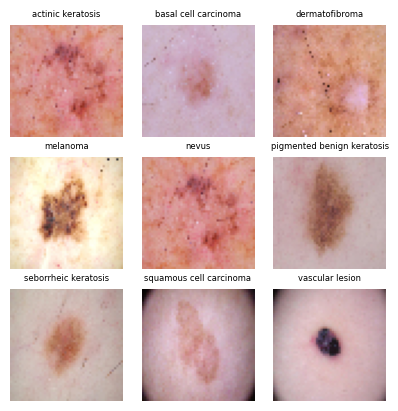

In [ ]:
#Visualize one instance of all the class present in the dataset.

#image_dataset_from_directory() will return a tf.data.Dataset that yields batches of images from the subdirectories.
#label_mode is categorial, the labels are a float32 tensor of shape (batch_size, num_classes), representing a one-hot encoding of the class index.
image_dataset = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,image_size=(180,180),
                                                                    label_mode='categorical',seed=123)


class_names = sorted(os.listdir(data_dir_train))  # Ensure consistent order

# Dictionary to store file paths of each class
image_paths_by_class = {class_name: [] for class_name in class_names}

# Populate the dictionary with file paths
for class_name in class_names:
    class_folder_path = os.path.join(data_dir_train, class_name)
    image_paths_by_class[class_name] = [
        os.path.join(class_folder_path, file_name)
        for file_name in os.listdir(class_folder_path)
        if file_name.lower().endswith(('jpg', 'jpeg', 'png'))
    ]

# Set up an even smaller figure size
plt.figure(figsize=(4, 4))  # Reduce overall output size
index = 0

for class_name in class_names[:9]:  # Select up to 9 classes
    image_list = image_paths_by_class[class_name][:1]  # Get one image per class
    if image_list:  # Ensure there is an image
        index += 1
        plt.subplot(3, 3, index)
        plt.imshow(load_img(image_list[0], target_size=(50, 50)))  # Reduce image size
        plt.title(class_name, fontsize=6)  # Reduce font size
        plt.axis("off")

plt.tight_layout(pad=0.3)  # Minimize padding for a compact layout
plt.show()


**Visualize distribution of classes in the training dataset.**

In [ ]:
def class_distribution_count(directory):

    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))

    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]

    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(data_dir_train)
df

,Class,No. of Image
0,dermatofibroma,95
1,squamous cell carcinoma,181
2,melanoma,438
3,vascular lesion,139
4,actinic keratosis,114
5,nevus,357
6,pigmented benign keratosis,462
7,seborrheic keratosis,77
8,basal cell carcinoma,376


<Axes: xlabel='No. of Image', ylabel='Class'>

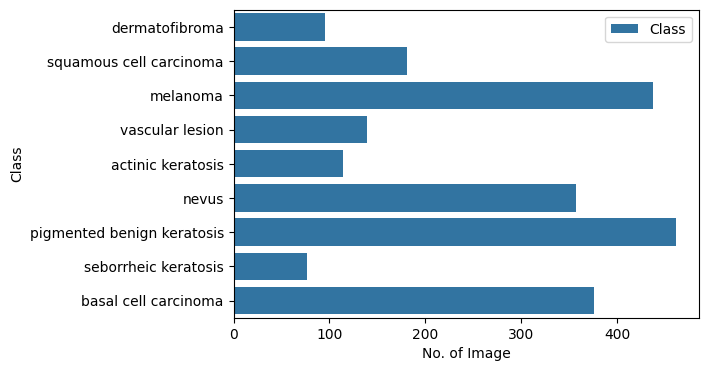

In [ ]:
#Visualize the Number of image in each class.
import seaborn as sns
plt.figure(figsize=(6, 4))
sns.barplot(x="No. of Image", y="Class", data=df,
            label="Class")

There is a class imbalance to solve this using a python package  Augmentor (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [ ]:
#install Augmentor
!pip install Augmentor

In [ ]:
path_to_training_dataset="/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)  #Adding 500 samples per class to make sure that none of the classes are sparse

Initialised with 114 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7CBB584AAD50>: 100%|██████████| 500/500 [00:13<00:00, 37.56 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7CBB5813CDD0>: 100%|██████████| 500/500 [00:13<00:00, 37.31 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7CBB58150E90>: 100%|██████████| 500/500 [00:13<00:00, 36.54 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=722x542 at 0x7CBB582CDC10>: 100%|██████████| 500/500 [01:12<00:00,  6.93 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=966x645 at 0x7CBB6B606750>: 100%|██████████| 500/500 [01:09<00:00,  7.16 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7CBB5ED7BFD0>: 100%|██████████| 500/500 [00:13<00:00, 37.66 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7CBB583754D0>: 100%|██████████| 500/500 [00:35<00:00, 14.04 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7CBB58286A10>: 100%|██████████| 500/500 [00:14<00:00, 35.09 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7CBB58249C10>: 100%|██████████| 500/500 [00:13<00:00, 36.61 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7CBB583084D0>: 100%|██████████| 500/500 [00:17<00:00, 28.54 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7CBB58142150>: 100%|██████████| 500/500 [00:17<00:00, 28.13 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=2048x1536 at 0x7CBB58261F10>: 100%|██████████| 500/500 [01:14<00:00,  6.74 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7CBB5C6BF990>: 100%|██████████| 500/500 [00:13<00:00, 38.14 Samples/s]


Initialised with 114 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7CBB5834D250>: 100%|██████████| 500/500 [00:13<00:00, 36.93 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=919x802 at 0x7CBB5864B0D0>: 100%|██████████| 500/500 [01:15<00:00,  6.62 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7CBB5813CDD0>: 100%|██████████| 500/500 [00:13<00:00, 36.30 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7CBB5820C050>: 100%|██████████| 500/500 [00:33<00:00, 15.03 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7CBB58218DD0>: 100%|██████████| 500/500 [00:13<00:00, 37.41 Samples/s]
<ipython-input-11-3a056bca1226>:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='No. of Images (Original + Augmented)', y='Class', data=df, palette="viridis")


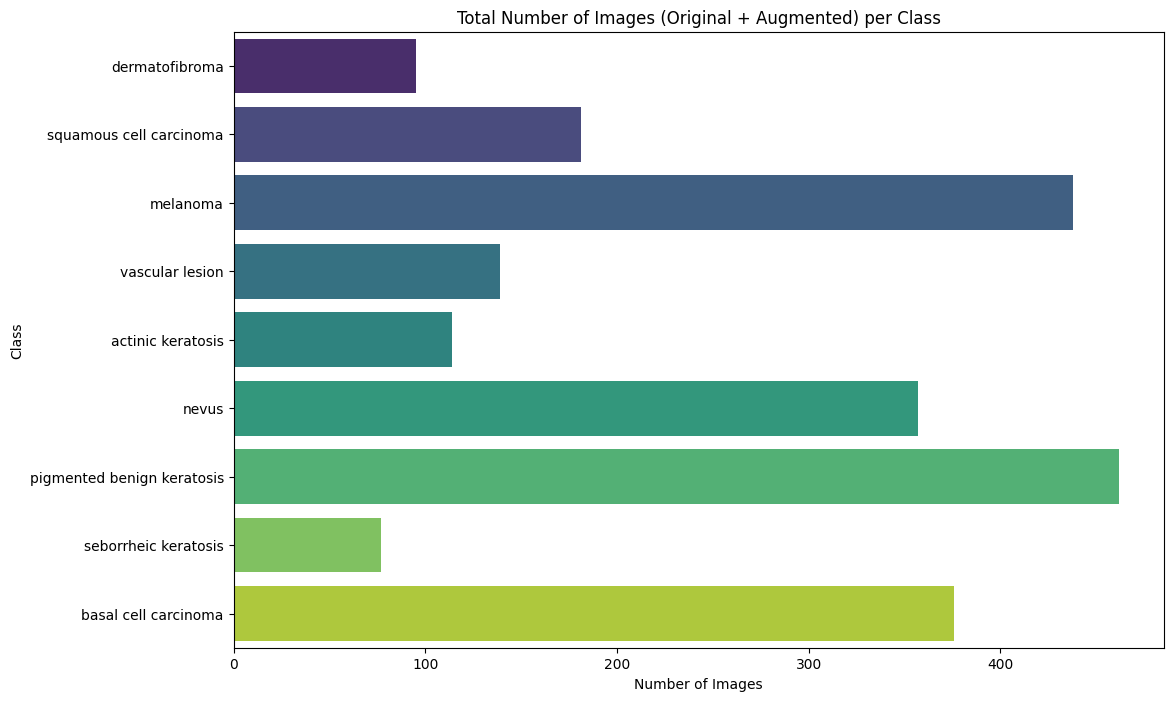

In [ ]:
import Augmentor
import pathlib
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Path to the training dataset
path_to_training_dataset = "/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"

# Run Augmentor for each class and generate augmented images
class_names = os.listdir(path_to_training_dataset)  # Get class names

# Apply augmentation
for class_name in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + class_name)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)  # Adding 500 samples per class

# Function to count original + augmented images per class
def count_images(directory):
    class_counts = []
    for class_dir in pathlib.Path(directory).iterdir():
        if class_dir.is_dir():
            # Count all images (original + augmented) in each class folder
            image_count = len([file for file in os.listdir(class_dir) if file.endswith(('jpg', 'jpeg', 'png'))])
            class_counts.append(image_count)

    # Get class names (subdirectories)
    class_names = [class_dir.name for class_dir in pathlib.Path(directory).iterdir() if class_dir.is_dir()]

    return class_names, class_counts

# Call the function to count images after augmentation
class_names, class_counts = count_images(path_to_training_dataset)

# Create a DataFrame to store class names and image counts
df = pd.DataFrame({'Class': class_names, 'No. of Images (Original + Augmented)': class_counts})

# Plot the bar graph using Seaborn
plt.figure(figsize=(12, 8))
sns.barplot(x='No. of Images (Original + Augmented)', y='Class', data=df, palette="viridis")
plt.title('Total Number of Images (Original + Augmented) per Class')
plt.xlabel('Number of Images')
plt.ylabel('Class')
plt.show()


In [ ]:
#Count total number of image generated by Augmentor.
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

9000


Total number of augmented images: 9000


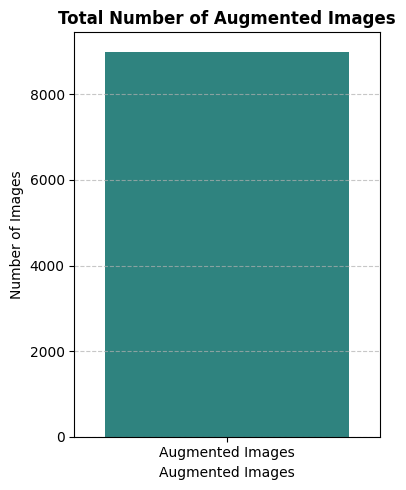

In [ ]:
import pathlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Path to the training dataset
data_dir_train = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")

# Count total number of augmented images generated by Augmentor
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(f"Total number of augmented images: {image_count_train}")

# Create a DataFrame for visualization
df = pd.DataFrame({'Augmented Images': [image_count_train]})

# Plotting the bar graph with the corrected syntax
plt.figure(figsize=(4, 5))  # Further reduced width and height for a more compact look
sns.barplot(x=['Augmented Images'], y=df['Augmented Images'], hue=['Augmented Images'], palette="viridis")

# Adding titles and labels with enhanced styling
plt.title('Total Number of Augmented Images', fontsize=12, fontweight='bold')
plt.ylabel('Number of Images', fontsize=10)
plt.xlabel('Augmented Images', fontsize=10)

# Customize the ticks for better readability
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Adding grid for better visual alignment
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.tight_layout()
plt.show()


**Model Building**

Found 11239 files belonging to 9 classes.
Using 8992 files for training.


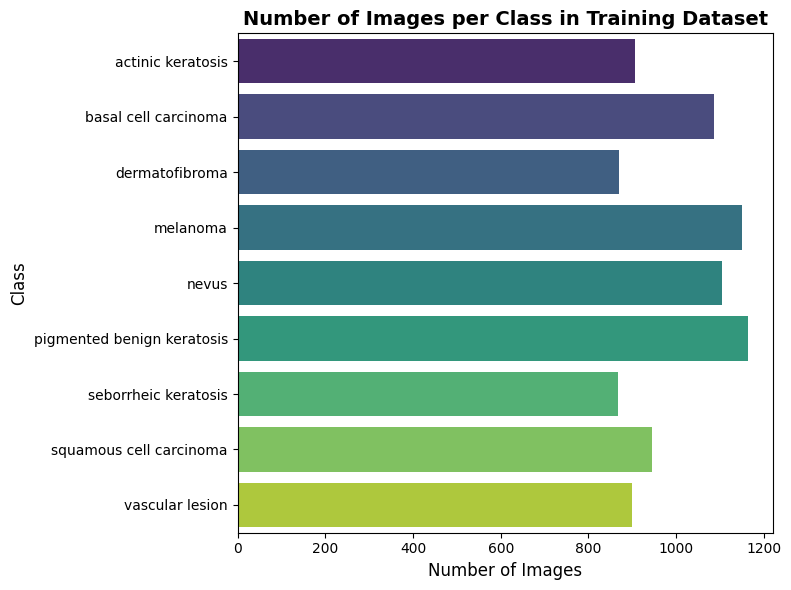

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Load the train dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    batch_size=32,
    image_size=(180,180),
    label_mode='categorical',
    seed=123,
    subset="training",
    validation_split=0.2
)

# Get the class names
class_names = train_ds.class_names

# Count the number of images per class
class_counts = {class_name: 0 for class_name in class_names}

for images, labels in train_ds:
    for i, label in enumerate(labels):
        class_index = tf.argmax(label).numpy()  # Get the index of the class
        class_counts[class_names[class_index]] += 1

# Convert counts to a DataFrame for visualization
df = pd.DataFrame(list(class_counts.items()), columns=["Class", "No. of Images"])

# Plot the image count for each class using a bar chart
plt.figure(figsize=(8, 6))
sns.barplot(x='No. of Images', y='Class', data=df, hue='Class', palette="viridis", legend=False)

# Adding titles and labels
plt.title('Number of Images per Class in Training Dataset', fontsize=14, fontweight='bold')
plt.xlabel('Number of Images', fontsize=12)
plt.ylabel('Class', fontsize=12)

# Display the plot
plt.tight_layout()
plt.show()


Found 11239 files belonging to 9 classes.
Using 2247 files for validation.


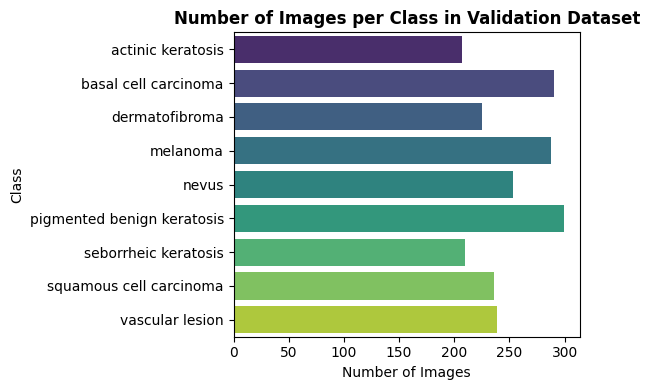

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Load the validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    batch_size=32,
    image_size=(180, 180),
    label_mode='categorical',
    seed=123,
    subset="validation",
    validation_split=0.2
)

# Get the class names from the validation dataset
class_names = val_ds.class_names

# Count the number of images per class in the validation set
val_class_counts = {class_name: 0 for class_name in class_names}

for images, labels in val_ds:
    for i, label in enumerate(labels):
        class_index = tf.argmax(label).numpy()  # Get the index of the class
        val_class_counts[class_names[class_index]] += 1

# Convert counts to a DataFrame for visualization
df_val = pd.DataFrame(list(val_class_counts.items()), columns=["Class", "No. of Images"])

# Plot the image count for each class in the validation set using a bar chart
plt.figure(figsize=(6, 4))  # Reduced figure size
sns.barplot(x='No. of Images', y='Class', data=df_val, hue='Class', palette="viridis", legend=False)

# Adding titles and labels
plt.title('Number of Images per Class in Validation Dataset', fontsize=12, fontweight='bold')
plt.xlabel('Number of Images', fontsize=10)
plt.ylabel('Class', fontsize=10)

# Display the plot
plt.tight_layout()
plt.show()


In [ ]:
#tf.data.experimental.AUTOTUNE defines appropriate number of processes that are free for working.

#`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

#`Dataset.prefetch()` overlaps data preprocessing and model execution while training.


AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


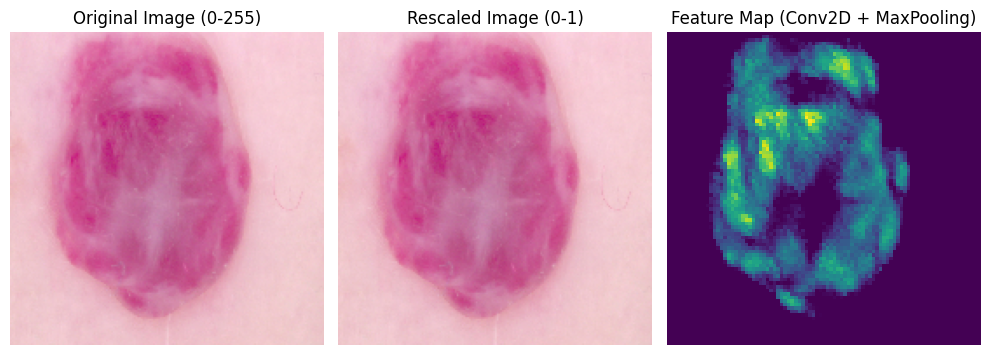

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Load and preprocess the image
image_path = '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/ISIC_0026349.jpg'  # Change to your image path
image = tf.keras.preprocessing.image.load_img(image_path, target_size=(180, 180))
image_array = tf.keras.preprocessing.image.img_to_array(image)

# Step 1: Visualize the Original Image (Pixel values in range [0, 255])
plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 1)
plt.imshow(image_array.astype("uint8"))
plt.title("Original Image (0-255)")
plt.axis("off")

# Step 2: Visualize the Image After Rescaling (Pixel values in range [0, 1])
image_rescaled = image_array / 255.0  # Rescale the image
plt.subplot(1, 3, 2)
plt.imshow(image_rescaled)
plt.title("Rescaled Image (0-1)")
plt.axis("off")

# Step 3: Create a simple model with Conv2D and MaxPooling to see processed features
model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255, input_shape=(180, 180, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2))
])

# Add batch dimension and pass through the model
image_batch = tf.expand_dims(image_rescaled, axis=0)  # Add batch dimension
processed_image = model(image_batch)

# Step 4: Visualize the processed image (Feature Map after Conv2D + MaxPooling)
# For simplicity, we'll visualize the output of the Conv2D layer
feature_map = processed_image[0].numpy()  # Get the feature map (1st image from batch)
plt.subplot(1, 3, 3)
plt.imshow(feature_map[:, :, 0], cmap='viridis')  # Visualize 1st channel of feature map
plt.title("Feature Map (Conv2D + MaxPooling)")
plt.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
from tensorflow.keras import layers, Sequential

model = Sequential()

# Use the correct path for Rescaling layer
model.add(layers.Rescaling(1./255, input_shape=(180, 180, 3)))  # Rescaling Layer

# First Convolution layer
model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2, 2)))

# Second Convolution Layer
model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2, 2)))

# Third Convolution Layer
model.add(layers.Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2, 2)))

# Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

# Flatten Layer
model.add(layers.Flatten())

# Dense Layer
model.add(layers.Dense(128, activation='relu'))

# Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

# Dense Layer with softmax activation function.
model.add(layers.Dense(len(class_names), activation='softmax'))

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       6,553,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,648,137 (25.36 MB)

 Trainable params: 6,648,137 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

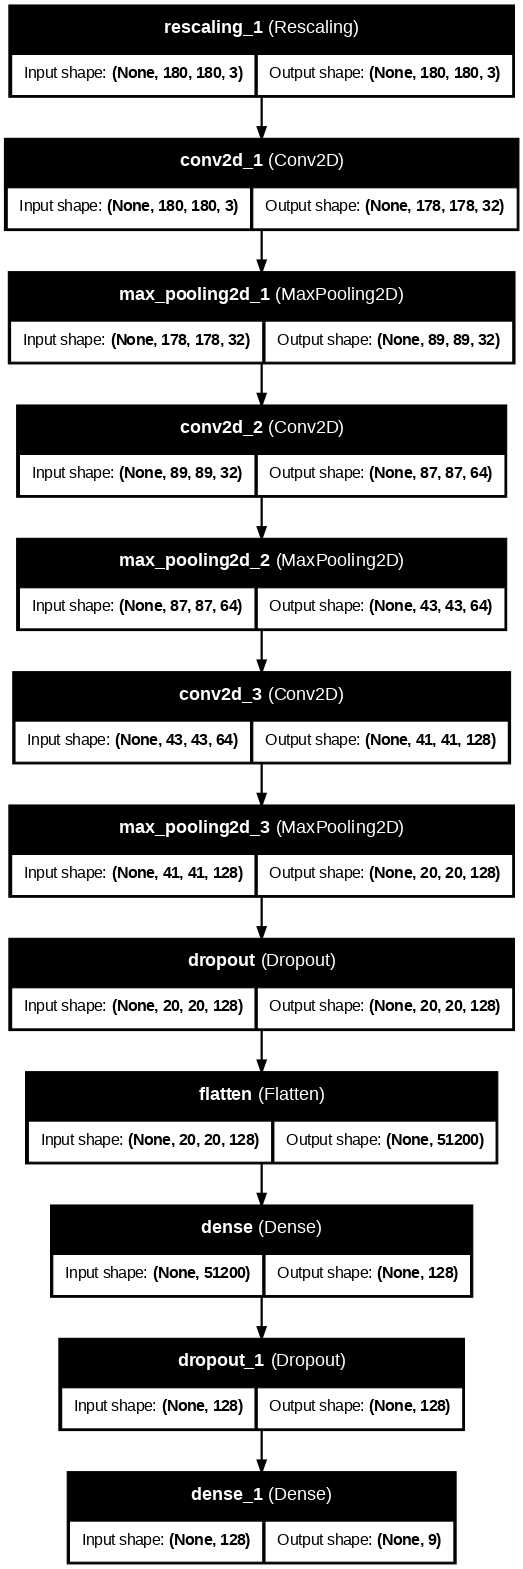

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True, dpi=80)


In [ ]:
#Compile the Model

#Adam optimization: is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.
#categorical_crossentropy: Used as a loss function for multi-class classification model where there are two or more output labels.

model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])

#ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval,
#so the model or weights can be loaded later to continue the training from the state saved.
checkpoint = ModelCheckpoint("model.keras",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
#Stop training when a monitored metric has stopped improving.
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto",verbose=1)

In [ ]:
# Train the model
epochs = 20
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs,callbacks=[checkpoint,earlystop])

Epoch 1/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.2717 - loss: 1.8831
Epoch 1: val_accuracy improved from -inf to 0.44504, saving model to model.keras
281/281 ━━━━━━━━━━━━━━━━━━━━ 55s 75ms/step - accuracy: 0.2720 - loss: 1.8823 - val_accuracy: 0.4450 - val_loss: 1.5124
Epoch 2/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.4751 - loss: 1.3830
Epoch 2: val_accuracy improved from 0.44504 to 0.54517, saving model to model.keras
281/281 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - accuracy: 0.4752 - loss: 1.3828 - val_accuracy: 0.5452 - val_loss: 1.1917
Epoch 3/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5588 - loss: 1.1798
Epoch 3: val_accuracy improved from 0.54517 to 0.66222, saving model to model.keras
281/281 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - accuracy: 0.5588 - loss: 1.1797 - val_accuracy: 0.6622 - val_loss: 0.9661
Epoch 4/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6387 - loss: 0.9685
Epoch 4: val_accuracy improved from 0.66222 to 0

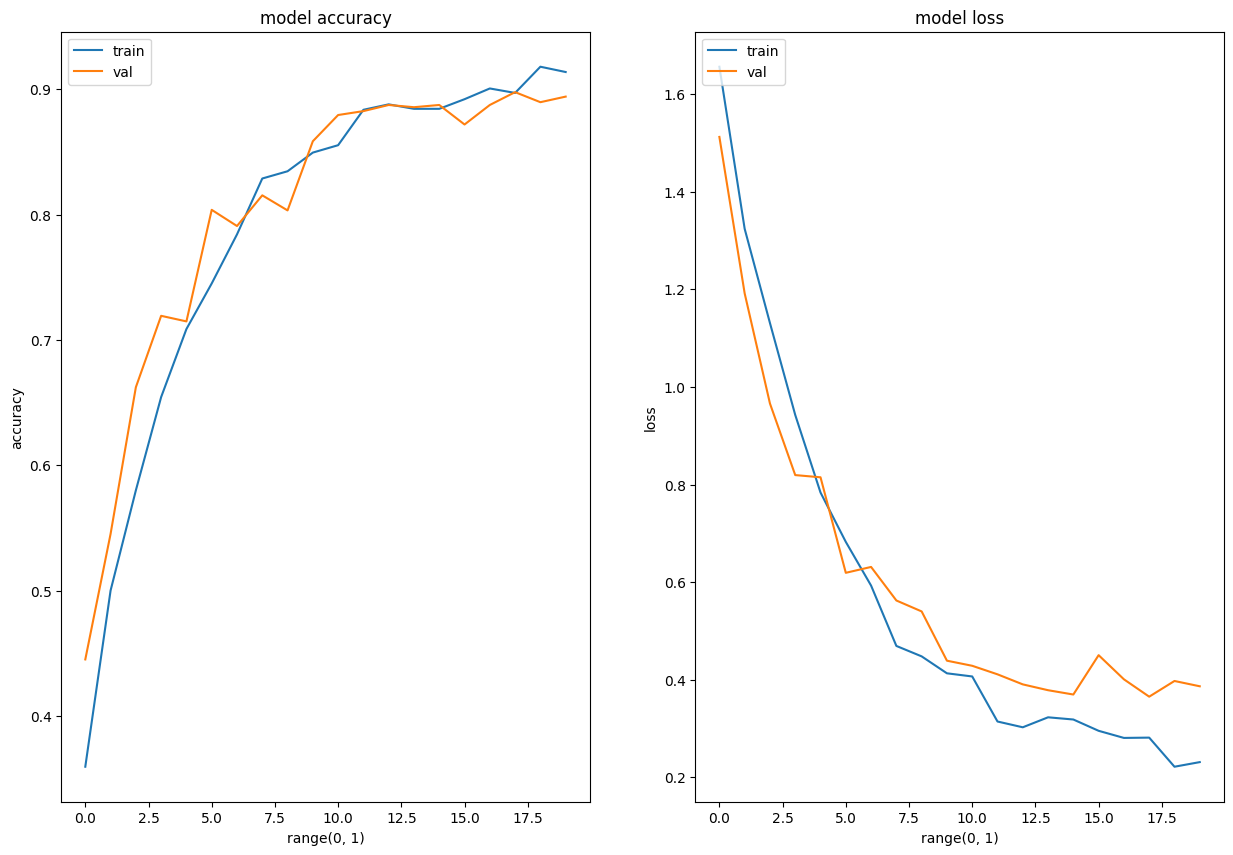

In [ ]:
# Plot the training curves

epochs_range = range(earlystop.stopped_epoch+1)

plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)

#Plot Model Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')

#Plot Model Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [ ]:
import os

Test_image_path = "/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/ISIC_0026349.jpg"


# Check if the file exists
if os.path.exists(Test_image_path):
    print("File exists:", Test_image_path)
else:
    print("File not found. Check the path!")


File exists: /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/ISIC_0026349.jpg


## Model Prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 794ms/step


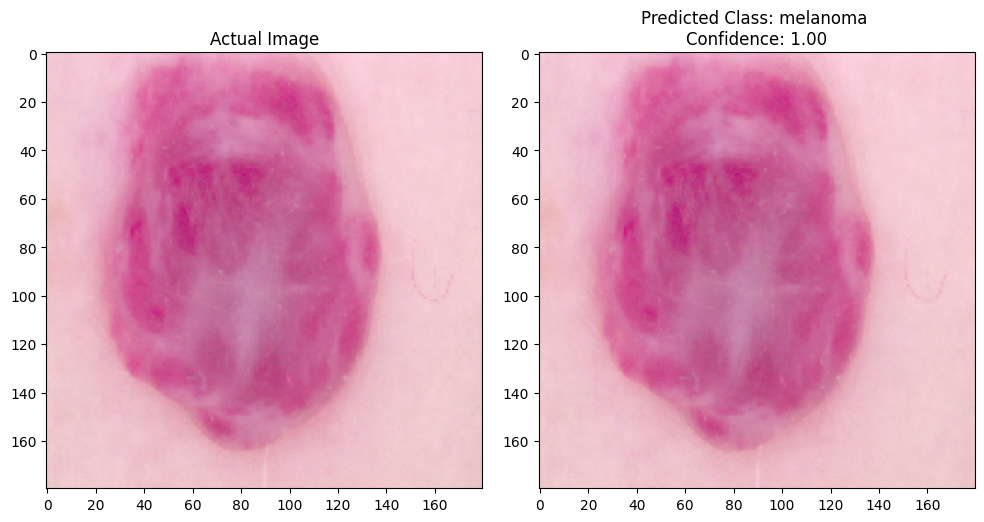

Predicted Class: melanoma
Prediction Probabilities:  [[0.0000000e+00 0.0000000e+00 0.0000000e+00 1.0000000e+00 7.1838129e-34
  2.7695918e-37 1.5841410e-20 0.0000000e+00 0.0000000e+00]]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from glob import glob
import os

# Assuming 'class_names' and 'model' are defined
# Specify the path to the new image you want to test

Test_image_path = "/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/ISIC_0026349.jpg"


# Load the test image and display it
Test_image_loaded = image.load_img(Test_image_path, target_size=(180, 180))
plt.figure(figsize=(10, 5))

# Display the actual image
plt.subplot(1, 2, 1)
plt.imshow(Test_image_loaded)
plt.title(f"Actual Image")
plt.grid(False)

# Convert image to array
img_array = image.img_to_array(Test_image_loaded)

# Rescale the image (same scaling as training images)
img_array = img_array / 255.0  # Rescale image values to between 0 and 1

# Add batch dimension (since model expects 4D input shape)
img_array = np.expand_dims(img_array, axis=0)  # Shape becomes (1, 180, 180, 3)

# Predict the class
pred = model.predict(img_array)

# Get the predicted class index (the class with the highest probability)
pred_class_idx = np.argmax(pred)

# Get the predicted class name
pred_class = class_names[pred_class_idx]

# Display the predicted image with predicted class
plt.subplot(1, 2, 2)
plt.imshow(Test_image_loaded)
plt.title(f"Predicted Class: {pred_class} \nConfidence: {pred[0][pred_class_idx]:.2f}")
plt.grid(False)

# Show the images and titles
plt.tight_layout()
plt.show()

# Print the actual and predicted class names
print("Predicted Class: " + pred_class)

# Print the prediction probabilities for debugging
print("Prediction Probabilities: ", pred)


In [ ]:

# Import necessary libraries for traditional ML models
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
# Import necessary libraries for traditional ML models
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model



In [ ]:

# Import necessary libraries for traditional ML models
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model

# Load pre-trained VGG16 model for feature extraction
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
feature_extractor = Model(inputs=base_model.input, outputs=base_model.output)

# Function to extract features
def extract_features(directory):
    features = []
    labels = []
    class_names = sorted([item.name for item in directory.glob('*') if item.is_dir()])

    for class_index, class_name in enumerate(class_names):
        class_path = directory / class_name
        for img_path in class_path.glob('*.jpg'):
            img = load_img(img_path, target_size=(224, 224))
            img_array = np.array(img) / 255.0
            img_array = np.expand_dims(img_array, axis=0)
            feature = feature_extractor.predict(img_array)
            feature = feature.flatten()
            features.append(feature)
            labels.append(class_index)

    return np.array(features), np.array(labels)

# Extract features for train and test datasets
X_train, Y_train = extract_features(data_dir_train)
X_test, Y_test = extract_features(data_dir_test)
print("Feature extraction completed!")


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1